# Bankruptcy in Taiwan 🇹🇼

In [ ]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from ipywidgets import interact
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import accuracy_score

In [25]:
# Load data file
import pandas as pd

taiwan_data = pd.read_csv("data.csv")


In [26]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

Index(['bankrupt', 'feat_1', 'feat_2',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate',
       ' Regular Net Profit Growth Rate

In [28]:
n_companies = len(taiwan_data)
print(n_companies)

6819


In [ ]:
n_features = df.shape[1] - 1  # Excluye la columna "bankrupt"
print(f"Number of features: {n_features}")

Number of features: 95


In [32]:
import pandas as pd

def wrangle(filename):
    """
    Read a CSV file and prepare the data for modeling.

    Parameters:
        filename (str): Path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame with 'bankrupt' column converted to boolean.
    """
    # Load the dataset
    df = pd.read_csv(filename)

    # Convert the 'bankrupt' column from 1/0 to True/False
    df["bankrupt"] = df["bankrupt"].astype(bool)

    return df

# Load and wrangle the dataset
df = wrangle("data.csv")

# Display basic info
print("df shape:", df.shape)
df.head()

df shape: (6819, 96)


,bankrupt,feat_1,feat_2,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [33]:
nans_by_col = df.isna().sum()  
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


bankrupt                                              0
feat_1                                                0
feat_2                                                0
 ROA(B) before interest and depreciation after tax    0
 Operating Gross Margin                               0
dtype: int64

### Class Balance Visualization

The plot below shows the distribution of the target variable `bankrupt`. As observed, the dataset is **highly imbalanced**, with very few companies marked as bankrupt (`True`). This insight is critical because most machine learning models assume a balanced dataset, and imbalanced data may require additional preprocessing (e.g., resampling).

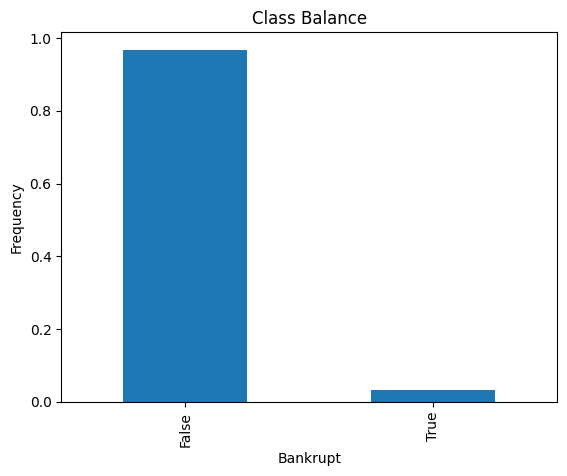

In [ ]:
import matplotlib.pyplot as plt

# Calculate normalized class distribution for the 'bankrupt' target variable
value_counts = df["bankrupt"].value_counts(normalize=True)

fig, ax = plt.subplots()
value_counts.plot(kind="bar", ax=ax)
ax.set_xlabel("Bankrupt")
ax.set_ylabel("Frequency")
ax.set_title("Class Balance")
plt.show()

In [ ]:
# Define the target column
target = "bankrupt"

X = df.drop(columns = [target])
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6819, 95)
y shape: (6819,)


In [ ]:
# Split the dataset into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


In [ ]:
# Apply random oversampling to balance the training data
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (10558, 95)


,feat_1,feat_2,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.493784,0.550153,0.544622,0.598524,0.598524,0.998980,0.797443,0.809355,0.303595,0.781616,...,0.806631,0.001637,0.623661,0.598521,0.840649,0.276281,0.026814,0.565265,1,0.070742
1,0.534393,0.590765,0.573425,0.599302,0.599173,0.999023,0.797454,0.809359,0.303524,0.781621,...,0.827723,0.001079,0.624307,0.599298,0.843248,0.282615,0.026852,0.565433,1,0.022433
2,0.526398,0.586895,0.566519,0.606740,0.606740,0.999103,0.797606,0.809470,0.303622,0.781718,...,0.828627,0.002505,0.624714,0.606739,0.841982,0.276632,0.026791,0.565159,1,0.059856
3,0.469702,0.536851,0.521066,0.595375,0.595375,0.998967,0.797390,0.809313,0.303530,0.781572,...,0.797846,0.003100,0.624621,0.595370,0.840248,0.283786,0.027673,0.567450,1,0.020864
4,0.391557,0.443197,0.432464,0.664495,0.664495,0.995856,0.794096,0.806216,0.304281,0.777918,...,0.756573,0.000198,0.624242,0.664491,0.838115,0.275114,0.026791,0.565158,1,0.233952


In [ ]:
# Instantiate a base Random Forest classifier
clf = RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the base model using cross-validation
cv_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_scores)

[0.99100379 0.99195076 0.99715909 0.99526291 0.9947892 ]


In [ ]:
# Define the hyperparameter grid to search
params = {
    "max_depth": range(30, 50, 10),
    "n_estimators": range(25, 51, 25),
}

In [ ]:
# Set up GridSearchCV for hyperparameter tuning
model = GridSearchCV(
    clf,
    param_grid=params, 
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [44]:
# Train the model using the best combination of parameters

model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(30, 50, 10),
                         'n_estimators': range(25, 51, 25)},
             verbose=1)

In [45]:
# Convert GridSearchCV results to a DataFrame for inspection
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.452311,0.230632,0.029801,0.008325,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.989110,0.988636,0.994792,0.993842,0.993842,0.992044,0.002617,4
1,5.431688,0.454219,0.086403,0.014260,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.990057,0.990057,0.995265,0.994789,0.993842,0.992802,0.002288,3
2,2.664220,0.126967,0.049945,0.022211,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.990530,0.990057,0.995739,0.996210,0.995737,0.993655,0.002754,2
3,4.001562,0.598217,0.039582,0.016948,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.991477,0.991477,0.996686,0.997158,0.994315,0.994223,0.002440,1


In [46]:
# Retrieve the best hyperparameters found during the grid search
best_params = model.best_params_
print(best_params)

{'max_depth': 40, 'n_estimators': 50}


In [47]:
# Compute accuracy on training and test sets
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 1.0
Model Test Accuracy: 0.9699


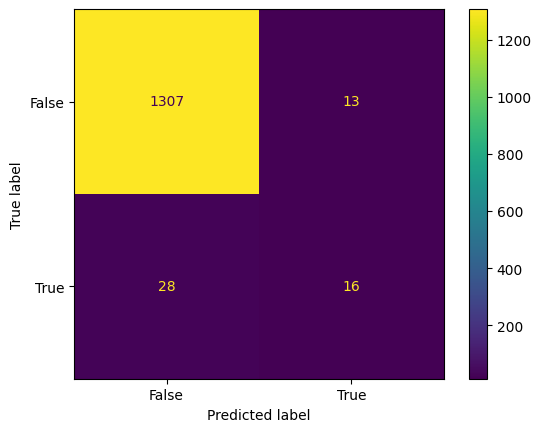

In [48]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)
plt.show()

The final model was evaluated on the test set using accuracy, confusion matrix, and classification report. These metrics provide insights into the model's performance on detecting bankrupt companies, which is crucial given the original class imbalance.

In [49]:
y_pred = model.predict(X_test)

# Generate a detailed classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      1320
        True       0.55      0.36      0.44        44

    accuracy                           0.97      1364
   macro avg       0.77      0.68      0.71      1364
weighted avg       0.97      0.97      0.97      1364



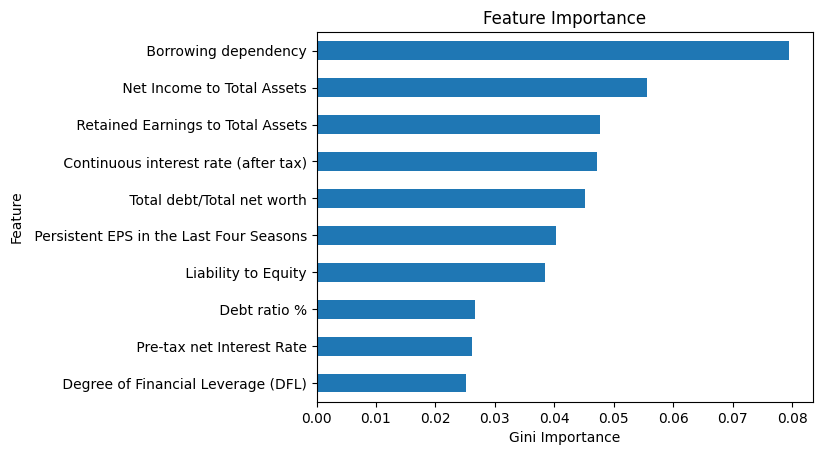

In [50]:
# Get feature importances from the best estimator found by GridSearchCV
importances = model.best_estimator_.feature_importances_

# Create a Series with feature names and their importances
feat_imp = pd.Series(importances, index=X_train_over.columns)

# Select the 10 most important features
top_10 = feat_imp.sort_values().tail(10)

fig, ax = plt.subplots()
top_10.plot(kind="barh", ax=ax)
ax.set_xlabel("Gini Importance")
ax.set_ylabel("Feature")
ax.set_title("Feature Importance")
plt.show()

In [ ]:
# Save the trained model to a pickle file
with open("model-5-5.pkl", "wb") as f:
    pickle.dump(model, f)